In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # set of tuple
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other): # self**other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward    
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # always "local" * "global" derivative: e.g. a -> b=e^a -> ... -> L, dL/da = db/da (i.e. b for b=e^a) * dL/db
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # only add node once all children added
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [29]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

dL / dc ?
dL / de ?

d = c + e
dd / dc = 1.0
dd / de = 1.0

L = d*f
dL / dd = f = -2.0

Chain rule:
dL / dc = (dL / dd) * (dd / dc) = -2.0
dL / de = (dL / dd) * (dd / de) = -2.0

dL / da ?
dL / db ?

e = a*b
de / da = b = -3.0
de / db = a = 2.0

Chain rule:
dL / da = (dL / de) * (de / da) =  -2.0 * -3.0 = 6.0
dL / db = (dL / de) * (de / db) = -2.0 * 2.0 = -4.0


In [30]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

In [31]:
lol()

6.000000000021544


# Neuron

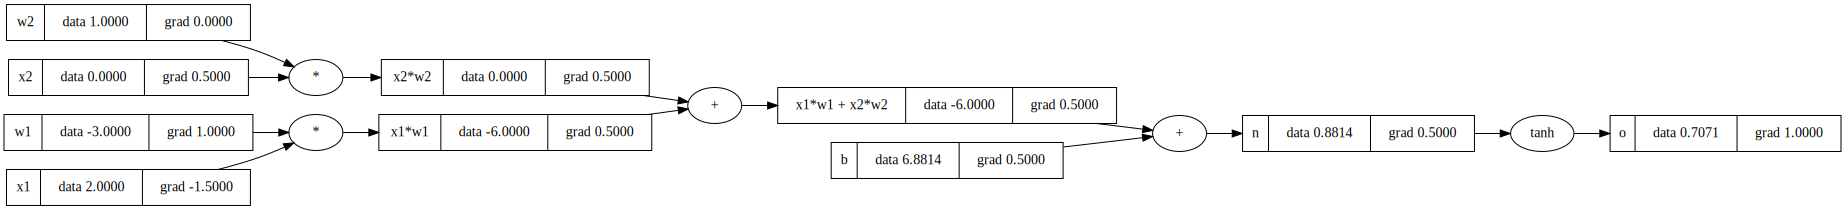

In [32]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

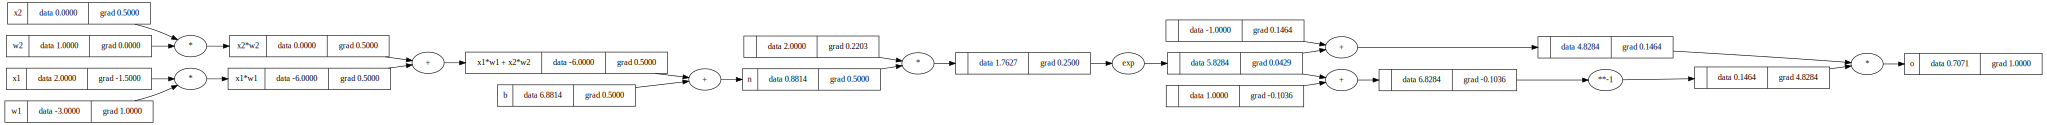

In [33]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----
o.label = 'o'
o.backward()
draw_dot(o)

# PyTorch equivalent

In [34]:
import torch

In [35]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

In [36]:
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [37]:
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item()) # extract value (number) with .item()
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Imitate PyTorch

In [38]:
import random

In [39]:
class Neuron:
    # neuron is fully connected to all nin inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # one weight per (input, neuron) combo
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): # used for e.g. n(x), x = [-2.0, 3.0], n = Neuron(2)
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    # list of nout neurons
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()] # single list comprehension
        
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        
        return params
    
class MLP:
    # multiple layers with number of neurons for each layer listed in nouts
    def __init__(self, nin, nouts):
        sz = [nin] + nouts 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [40]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.006867264697038538)

In [41]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [42]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.914424667323652)

In [43]:
loss.backward()

In [44]:
n.layers[0].neurons[0].w[0].grad

0.36806406341103637

In [45]:
len(n.parameters())

41

In [46]:
# gradient descent
for p in n.parameters():
    p.data += -0.01 * p.grad

### Gradient descent loop

In [47]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3636071483869078)

In [48]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [49]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent (param update)
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)
    

0 3.5941804836500957
1 2.9248247478368765
2 2.2131257232104136
3 1.6773047746961647
4 1.2328635148937606
5 0.857589293943706
6 0.5776076184686926
7 0.3951852203798869
8 0.28232241243127965
9 0.21156760351567538
10 0.16557268319868781
11 0.13436785234485887
12 0.11229985777595253
13 0.09610052412273407
14 0.08381805969177072
15 0.07424350868780054
16 0.06660078330127238
17 0.06037492410365257
18 0.05521387499373548
19 0.05087041994869019
